## Decision Trees

In [2]:
import numpy as np
import pandas as pd

import os
import time
import requests
import json
from pprint import pprint

from sklearn import tree
from sklearn.cross_validation import train_test_split
from sklearn.utils import check_random_state
from sklearn.metrics import accuracy_score

from nose.tools import assert_equal, assert_is_not, assert_is_instance
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_almost_equal
from pandas.util.testing import assert_frame_equal

import warnings
warnings.filterwarnings("ignore")

In [3]:
!ls weather | head

weather_kord_2001_0101.json
weather_kord_2001_0102.json
weather_kord_2001_0103.json
weather_kord_2001_0104.json
weather_kord_2001_0105.json
weather_kord_2001_0106.json
weather_kord_2001_0107.json
weather_kord_2001_0108.json
weather_kord_2001_0109.json
weather_kord_2001_0110.json


In [4]:
def from_json_to_dict(date, path='/Users/Constance/weather/', prefix='weather_kord_2001_'):
    '''
    Takes a string in the format MMDD where M = month, D = day of month.
    Read a json file at "path" + "prefix" + "date".
    Returns the JSON dictionary.
    
    Parameters
    ----------
    date: A string.
    
    Optional
    --------
    path: A string.
    prefix: A string.
    
    Returns
    -------
    A dict.
    '''
    suffix='.json'
    file=path+prefix+date+suffix
    with open(file,'r') as fin:
        data=json.load(fin)
    return data

In [5]:
test_0101_dict = from_json_to_dict('0101')
assert_is_instance(test_0101_dict, dict)
assert_equal('history' in test_0101_dict, True)
assert_equal('observations' in test_0101_dict['history'], True)
assert_is_instance(test_0101_dict['history']['observations'], list)

test_0103_dict = from_json_to_dict('0103')
assert_is_instance(test_0103_dict, dict)
assert_equal('history' in test_0103_dict, True)
assert_equal('observations' in test_0103_dict['history'], True)
assert_is_instance(test_0103_dict['history']['observations'], list)

In [97]:
data = from_json_to_dict('0101')
print(data.keys())

dict_keys(['response', 'current_observation', 'history'])


In [7]:
print(data['history'].keys())

dict_keys(['date', 'utcdate', 'observations', 'dailysummary'])


In [8]:
def from_dict_to_visibility(json_data):
    '''
    Takes a dictionary and returns a tuple of (Month, Day, Hour, Minute, Visibility).
    
    Parameters
    ----------
    json_data: A dict.
    
    Returns
    -------
    A 5-tuple (str, str, str, str, str)
    '''
    obs=json_data['history']['observations']
    result=[]
    for i in range(len(obs)):
        month=obs[i]['date']['mon']
        day=obs[i]['date']['mday']
        hour=obs[i]['date']['hour']
        minute=obs[i]['date']['min']
        visi=obs[i]['visi']
        one=(month,day,hour,minute,visi)
        result.append(one)
    return result

In [9]:
test_0101_visi = from_dict_to_visibility(test_0101_dict)
assert_is_instance(test_0101_visi, list)
assert_equal(len(test_0101_visi), 24)
for item in test_0101_visi:
    assert_is_instance(item, tuple)
    assert_equal(len(item), 5) # month, day, hour, minute, visibility
    assert_equal(item[0], '01')
    assert_equal(item[1], '01')
    
test_0103_visi = from_dict_to_visibility(test_0103_dict)
assert_is_instance(test_0103_visi, list)
assert_equal(len(test_0103_visi), 34) # some days have more than one measurement per hour
for item in test_0103_visi:
    assert_is_instance(item, tuple)
    assert_equal(len(item), 5)
    assert_equal(item[0], '01')
    assert_equal(item[1], '03')

In [10]:
dates = ['{0:0>2}{1:0>2}'.format(m, d + 1) for m in [1, 3, 5, 7, 8, 10, 12] for d in range(31)]
dates.extend(['{0:0>2}{1:0>2}'.format(m, d + 1) for m in [4, 6, 9, 11] for d in range(30)])
dates.extend(['02{0:0>2}'.format(d + 1) for d in range(28)])
dates.sort()

assert_equal(len(dates), 365)

print("The first five elements are {}".format(dates[:5]))
print("The last five elements are {}".format(dates[-5:]))

The first five elements are ['0101', '0102', '0103', '0104', '0105']
The last five elements are ['1227', '1228', '1229', '1230', '1231']


In [11]:
def collect_365_days(dates):
    '''
    Uses from_json_to_dict() and from_dict_to_visiblility() to
    generate a list of tuples of the form
    (Month, Day, Hour, Minute, Visibility)
    
    Parameters
    ----------
    dates: A list of strings "MMDD"
    
    Returns
    -------
    A list of 5-tuples (str, str, str, str, str)
    '''
    result=[]
    for i in dates:
        new=from_dict_to_visibility(from_json_to_dict(i))
        result.append(new)
    visibilities=[]
    for j in result:
        for k in j:
            visibilities.append(k)
    return visibilities

In [12]:
visibilities = collect_365_days(dates)

print("The length of visibilities is {}.".format(len(visibilities)))
print("The first five elements of visibilities are {}".format(visibilities[:5]))

The length of visibilities is 10168.
The first five elements of visibilities are [('01', '01', '00', '56', '9.0'), ('01', '01', '01', '56', '7.0'), ('01', '01', '02', '56', '10.0'), ('01', '01', '03', '56', '10.0'), ('01', '01', '04', '56', '9.0')]


In [13]:
assert_is_instance(visibilities, list)
assert_equal(len(visibilities), 10168)
assert_equal(visibilities[:5],
    [('01', '01', '00', '56', '9.0'),
     ('01', '01', '01', '56', '7.0'),
     ('01', '01', '02', '56', '10.0'),
     ('01', '01', '03', '56', '10.0'),
     ('01', '01', '04', '56', '9.0')]
    )
assert_equal(visibilities[-5:],
    [('12', '31', '19', '56', '10.0'),
     ('12', '31', '20', '56', '10.0'),
     ('12', '31', '21', '56', '10.0'),
     ('12', '31', '22', '56', '10.0'),
     ('12', '31', '23', '56', '10.0')]
    )

In [14]:
df = pd.read_csv('2001.csv', encoding='latin-1', usecols=(1, 2, 5, 8, 15, 16))

In [15]:
local = df[(df['Origin'] == 'ORD') & (df['UniqueCarrier'] == 'AA')]
local = local.drop(['UniqueCarrier', 'Origin'], axis=1) # we don't need the Month and Origin columns anymore.
local['Delayed'] = (local['DepDelay'] > 15).astype(np.int) # 1 if a flight was delayed, 0 if not.
local = local.drop('DepDelay', axis=1).dropna() # we don't need the DepDelay column.

In [16]:
def from_string_to_numbers(visibilities):
    '''
    Takes a list of 5-tuples of strings.
    Convert the strings into integers in the form `mmddHHMM`,
    where `m` is month, `d` is day of month, `H` is hour, and `M` is minute.
    Returns a pandas.DataFrame with two columns "Time" and "Visibility".
    
    Parameters
    ----------
    visibilities: A list of 5-tuple of strings.
    
    Returns
    -------
    A pandas.DataFrame
    '''
    new=[]
    for i in visibilities:
        date=''.join(i)[:8]
        visi=''.join(i)[8:]
        anew=(date,visi)
        new.append(anew)
    result=pd.DataFrame(new,columns=('Time','Visibility'))
    result['Time']=result.Time.astype('int64')
    result['Visibility']=result.Visibility.astype('float64')
    return result

In [127]:
time_visi = from_string_to_numbers(visibilities)
time_visi.Visibility.unique()
time_visi.Time.dtype

dtype('int64')

In [18]:
visi0 = [
    ('01', '01', '06', '00', '1.0'),
    ('02', '31', '08', '00', '2.0'),
    ('10', '05', '07', '00', '3.0'),
    ('12', '29', '09', '00', '4.0'),
    ('09', '30', '23', '00', '5.0'),
    ('07', '04', '12', '00', '6.0'),
    ('05', '12', '15', '00', '7.0'),
    ('11', '11', '18', '00', '8.0')
]

visi_answer = pd.DataFrame({
    'Time': [1010600, 2310800, 10050700, 12290900,
             9302300, 7041200, 5121500, 11111800],
    'Visibility': [1., 2., 3., 4., 5., 6., 7., 8.]
    })

assert_frame_equal(from_string_to_numbers(visi0), visi_answer)

In [19]:
local.head()

,Month,DayofMonth,CRSDepTime,Delayed
398444,1,1,1905,1
398445,1,2,1905,1
398446,1,3,1905,1
398447,1,4,1905,0
398448,1,5,1905,1


In [20]:
def combine_time(df):
    '''
    Combines "Month", "DayofMonth", and "CRSDepTime" in the form mmddHHMM.
    Creates a new column named "Time".
    
    Parameters
    ----------
    df: A pandas.DataFrame
    
    Returns
    -------
    A pandas.DataFrame
    '''
    new=df.astype(str)
    new['DayofMonth']=new.DayofMonth.apply(lambda x: x.zfill(2))
    new['CRSDepTime']=new.CRSDepTime.apply(lambda x: x.zfill(4))
    new['Time']=new.Month+new.DayofMonth+new.CRSDepTime
    new=new.astype('int64')
    return new

In [21]:
time_delayed = combine_time(local)
print(time_delayed.head())
time_delayed.Time.dtype

        Month  DayofMonth  CRSDepTime  Delayed     Time
398444      1           1        1905        1  1011905
398445      1           2        1905        1  1021905
398446      1           3        1905        1  1031905
398447      1           4        1905        0  1041905
398448      1           5        1905        1  1051905


dtype('int64')

In [22]:
df0 = pd.DataFrame({
    'Month':      [  1,   2,  10,   12,   9,     7,    5,   11],
    'DayofMonth': [  1,  31,   5,   29,  30,     4,   12,   11],
    'CRSDepTime': [600, 800, 700,  900, 2300, 1200, 1500, 1800]
    })

df_answer = df0.join(pd.DataFrame({
    'Time': [1010600, 2310800, 10050700, 12290900, 9302300, 7041200, 5121500, 11111800]
    }))

assert_is_not(combine_time(df0), df0)
assert_frame_equal(combine_time(df0), df_answer)

In [23]:
def match_visibility(df_delayed, df_visibility):
    result = df_delayed.copy()
    for idx, row in result.iterrows():
        matched = (row['Time'] - df_visibility['Time']).abs().idxmin()
        result.loc[idx, 'Visibility'] = df_visibility.loc[matched, 'Visibility']
    return result

local_visi = match_visibility(time_delayed, time_visi)

print(local_visi.head())

        Month  DayofMonth  CRSDepTime  Delayed     Time  Visibility
398444      1           1        1905        1  1011905        10.0
398445      1           2        1905        1  1021905         9.0
398446      1           3        1905        1  1031905         5.0
398447      1           4        1905        0  1041905         7.0
398448      1           5        1905        1  1051905        10.0


In [24]:
local_visi = local_visi.drop(['Month', 'DayofMonth', 'Time'], axis=1)
print(local_visi.head())

        CRSDepTime  Delayed  Visibility
398444        1905        1        10.0
398445        1905        1         9.0
398446        1905        1         5.0
398447        1905        0         7.0
398448        1905        1        10.0


In [26]:
def split(df, test_column, test_size, random_state):
    '''
    Uses sklearn.train_test_split to split "df" into a testing set and a test set.
    The "test_columns" lists the column that we are trying to predict.
    All columns in "df" except "test_columns" will be used for training.
    The "test_size" should be between 0.0 and 1.0 and represents the proportion of the
    dataset to include in the test split.
    The "random_state" parameter is used in sklearn.train_test_split.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    test_columns: A list of strings
    test_size: A float
    random_state: A numpy.random.RandomState instance
    
    Returns
    -------
    A 4-tuple of pandas.DataFrames
    '''
    x=df.drop(test_column, axis=1)
    y=df[test_column]
    (X_train, X_test, y_train, y_test) = train_test_split(x, y, test_size=test_size,random_state=random_state)
    X_train=np.array(X_train)
    X_test=np.array(X_test)
    y_train=np.array(y_train).flatten()
    y_test=np.array(y_test).flatten()
    return X_train, X_test, y_train, y_test

In [27]:
X_train, X_test, y_train, y_test = split(
    df=local_visi,
    test_column=['Delayed'],
    test_size=0.2,
    random_state=check_random_state(0)
    )

In [33]:
def fit_and_predict(X_train, y_train, X_test, random_state):
    '''
    Fits Decision Trees.
    
    Parameters
    ----------
    X: A pandas.DataFrame. Training attributes.
    y: A pandas.DataFrame. Truth labels.
    
    Returns
    -------
    A numpy array.
    '''

    dtc = tree.DecisionTreeClassifier(random_state=random_state)
    dtc.fit(X_train, y_train)
    prediction=dtc.predict(X_test)
    return prediction

In [34]:
y_pred = fit_and_predict(X_train, y_train, X_test, random_state=check_random_state(0))
accuracy = accuracy_score(y_test, y_pred)
print('The accuracy score is {:0.2f}.'.format(accuracy))

The accuracy score is 0.82.


In [36]:
assert_is_instance(y_pred, np.ndarray)
assert_equal(len(y_pred), len(y_test))
assert_almost_equal(accuracy, 0.817207853501)

## Random Forests

In [545]:
% matplotlib inline

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import ensemble
from sklearn.cross_validation import train_test_split, KFold
from sklearn.utils import check_random_state
from sklearn.metrics import log_loss, roc_curve, roc_auc_score, auc

from nose.tools import assert_equal, assert_is_instance, assert_is_not, assert_in
from numpy.testing import assert_array_equal, assert_array_almost_equal
from pandas.util.testing import assert_frame_equal

import warnings
warnings.filterwarnings("ignore")

In [130]:
time_visi.drop_duplicates(inplace=True)

In [133]:
local_visi = match_visibility(time_delayed, time_visi)
local_visi = local_visi.drop(['Time'], axis=1)
print(local_visi.head())

        Month  DayofMonth  CRSDepTime  Delayed  Visibility
398444      1           1        1905        1        10.0
398445      1           2        1905        1         9.0
398446      1           3        1905        1         5.0
398447      1           4        1905        0         7.0
398448      1           5        1905        1        10.0


In [136]:
df = pd.read_csv('2001.csv', encoding='latin-1', usecols=(1, 2, 3, 5, 7, 18))

In [546]:
df = df.loc[local_visi.index, :]
df.loc[local_visi.index, 'Visibility'] = local_visi['Visibility']
df.loc[local_visi.index, 'Delayed'] = local_visi['Delayed']
local = df.reset_index(drop=True) # easier to reset the index in this problem

print(local.head())

   Month  DayofMonth  DayOfWeek  CRSDepTime  CRSArrTime  Distance  Visibility  \
0      1           1          1        1905        2159      1846        10.0   
1      1           2          2        1905        2159      1846         9.0   
2      1           3          3        1905        2159      1846         5.0   
3      1           4          4        1905        2159      1846         7.0   
4      1           5          5        1905        2159      1846        10.0   

   Delayed  
0        1  
1        1  
2        1  
3        0  
4        1  


In [547]:
def split(df, test_column, test_size, random_state):
    '''
    Uses sklearn.train_test_split to split "df" into a testing set and a test set.
    The "test_columns" lists the column that we are trying to predict.
    All columns in "df" except "test_columns" will be used for training.
    The "test_size" should be between 0.0 and 1.0 and represents the proportion of the
    dataset to include in the test split.
    The "random_state" parameter is used in sklearn.train_test_split.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    test_columns: A list of strings
    test_size: A float
    random_state: A numpy.random.RandomState instance
    
    Returns
    -------
    A 4-tuple of pandas.DataFrames
    '''
    x=df.drop(test_column, axis=1)
    y=df[test_column]
    (X_train, X_test, y_train, y_test) = train_test_split(x, y, test_size=test_size,random_state=random_state)
    X_train=np.array(X_train)
    X_test=np.array(X_test)
    y_train=np.array(y_train).flatten()
    y_test=np.array(y_test).flatten()
    return X_train, X_test, y_train, y_test

In [626]:
X_train, X_test, y_train, y_test = split(
    df=local,
    test_column=['Delayed'],
    test_size=0.2,
    random_state=check_random_state(0)
    )

In [549]:
def get_cv_indices(df, n_folds, random_state):
    '''
    Provides train/test indices to split data in train test sets.
    Split dataset into "n_folds" consecutive folds (no shuffling).
    
    Paramters
    ---------
    df: A pandas.DataFrame
    n_folds: integer
    random_state: A numpy.random.RandomState instance

    Returns
    -------
    An sklearn.cross_validation.KFold instance.
    '''
    result=KFold(len(df), n_folds=n_folds, random_state=random_state)
    return result

In [550]:
test_kf = get_cv_indices(
    pd.DataFrame({'a': np.arange(1000)}), 10, check_random_state(1)
    )
assert_is_instance(test_kf, KFold)
assert_equal(test_kf.n, 1000)
assert_equal(test_kf.n_folds, 10)
assert_array_equal(test_kf.random_state.choice(100, 5), check_random_state(1).choice(100, 5))

In [551]:
def get_rfc(n_estimators, max_features, random_state):
    '''
    A random forest classifier with two adjustable parameters:
    "n_estimators" and "max_features".
    Uses the default sklearn values for the remaining parameters.
    
    Parameters
    ----------
    n_estimators: An int
    max_features: An int
    random_state: A numpy.random.RandomState instance
    
    Returns
    -------
    An sklearn.ensemble.forest.RandomForestClassifier
    '''
    rfc = ensemble.RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, random_state=random_state)
    return rfc

In [552]:
test_rfc = get_rfc(100, 10, check_random_state(1))
assert_is_instance(test_rfc, ensemble.RandomForestClassifier)
assert_equal(test_rfc.n_estimators, 100)
assert_equal(test_rfc.max_features, 10)
assert_array_equal(test_rfc.random_state.choice(100, 5), check_random_state(1).choice(100, 5))

In [553]:
def get_proba(clf, X_train, y_train, idx_train, idx_valid):
    '''
    
    Fits the "clf" model on X_train[idx_train] and y_train[idx_train].
    Makes predictions on X_train[idx_valid].
    
    Parameters
    ----------
    clf: An sklearn classifier instance.
    X_train: A pandas.DataFrame
    y_train: A pandas.DataFrame
    idx_train: A numpy array
    idx_valid: A numpy array
    
    Returns
    -------
    A two-dimensional numpy array
    '''
    x_train=np.array(X_train)
    Y_train=np.array(y_train)
    clf.fit(x_train[idx_train], Y_train[idx_train])
    y_pred=clf.predict_proba(x_train[idx_valid])
    return y_pred

In [554]:
test_X = pd.DataFrame({
    'X0': np.arange(10),
    'X1': np.arange(10),
    'X2': np.arange(10)
    })

test_y = pd.DataFrame({
    'y': np.arange(10)
    })

test_rfc = get_rfc(10, 2, check_random_state(2))

test_proba = get_proba(test_rfc, test_X, test_y,
    np.arange(10)[::2], np.arange(10)[::2] + 1)

assert_array_equal(test_proba,
    np.array(
        [[ 0.6,  0.2,  0.1,  0.1,  0. ],
         [ 0. ,  0.6,  0.3,  0.1,  0. ],
         [ 0. ,  0.2,  0.5,  0.3,  0. ],
         [ 0. ,  0.1,  0.1,  0.5,  0.3],
         [ 0. ,  0.1,  0.1,  0.1,  0.7]])
    )

In [587]:
def get_auc(kf, rfc, X_train, y_train):
    '''
    Iterates through the cross-validation folds and
    returns the area under the ROC curve for the validation data.
    
    Parameters
    ----------
    kf: An sklearn.KFold instance
    rfc: An sklearn.RandomForestClassifer instance
    X_train: A pandas.DataFrame
    y_train: A pandas.DataFrame
    
    Returns
    -------
    A numpy array
    '''
    result=[]
    for idx_train, idx_valid in kf:
        y_pred=get_proba(rfc, X_train, y_train, idx_train, idx_valid)
        y_test=np.array(y_train)[idx_valid]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
        roc_auc = auc(fpr, tpr)
        result.append(roc_auc)
    return np.array(result)

In [588]:
test_X = pd.DataFrame({
    'X0': np.arange(100),
    'X1': np.arange(100),
    'X2': np.arange(100)
    })

test_y = pd.DataFrame({
    'y': [0, 1] * 50
    })

test_kf = get_cv_indices(test_X, 10, check_random_state(1))

test_rfc = get_rfc(10, 2, check_random_state(2))

test_auc = get_auc(test_kf, test_rfc, test_X, test_y)

assert_array_almost_equal(test_auc,
    [0.5, 0.44, 0.44, 0.4, 0.4, 0.48, 0.48, 0.38, 0.4, 0.5]
    )

In [589]:
result = []

print('Trees   AUC\n'
      '------------')

for n_trees in range(10, 110, 10):
    kf = get_cv_indices(X_train, 3, check_random_state(0))
    rfc = get_rfc(n_trees, 3, check_random_state(0))
    mean_auc = get_auc(kf, rfc, X_train, y_train).mean()
    result.append((n_trees, mean_auc))
    print('{0:3d}    {1:0.3f}'.format(n_trees, mean_auc))

Trees   AUC
------------
 10    0.702
 20    0.716
 30    0.722
 40    0.726
 50    0.728
 60    0.729
 70    0.730
 80    0.731
 90    0.731
100    0.732


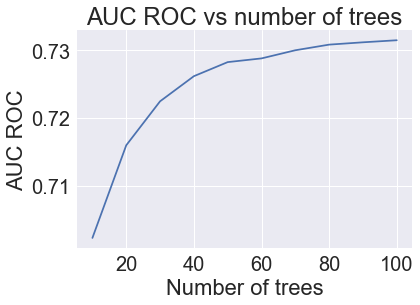

In [590]:
result = np.array(result)
fig, ax = plt.subplots()

ax.plot(result[:, 0], result[:, 1])
ax.set_title('AUC ROC vs number of trees')
ax.set_xlabel('Number of trees')
ax.set_ylabel('AUC ROC')

In [602]:
def optimize_max_features(X_train, y_train, cv_random_state, clf_random_state, n_folds=4, n_trees=20):
    '''
    
    Parameters
    ----------
    X_train: A pandas.DataFrame
    y_train: A pandas.DataFrame
    cv_random_state: A RandomState instance for get_cv_indices()
    clf_random_state: A RandomState instance for get_auc()
    
    Optional
    --------
    n_folds: An int. 4 by default.
    n_trees: An int. 20 by default.
    
    Returns
    --------
    A list of (max_features value, corresponding mean AUC value) tuples.
    '''

    kf =get_cv_indices(X_train, n_folds, cv_random_state)
    result=[]
    for i in range(1,8):
        rfc=get_rfc(n_trees, i, clf_random_state)
        mean_auc=get_auc(kf, rfc, X_train, y_train).mean()
        result.append((i,mean_auc))
    return result      

In [603]:
test_omf = optimize_max_features(X_train[:100], y_train[:100], check_random_state(0), check_random_state(0))
assert_is_instance(test_omf, list)

In [605]:
max_features = optimize_max_features(X_train, y_train, check_random_state(0), check_random_state(0))

In [612]:
best_max_features = np.argmax(np.array(max_features)[:, 1])+1
print('The best value for max_features is {}.'.format(best_max_features))
assert_equal(best_max_features, 5)

The best value for max_features is 5.


In [615]:
def get_final_rfc(X_train, y_train, X_test, max_features, random_state, n_trees=100):
    '''
    Trains a Random Forest classifier on the entire training set
    using the optimized "max_features".
    Makes probabilistic predictions.
    
    Parameters
    ----------
    X_train: A pandas.DataFrame
    y_train: A pandas.DataFrame
    X_test: A pandas.DataFrame
    max_features: An int
    random_state: A RandomState instance
    
    Optional
    --------
    n_trees: An int. 100 by default
    
    Returns
    -------
    A two-dimensional numpy array
    '''
    rfc=get_rfc(n_trees, max_features, random_state)
    x_train=np.array(X_train)
    Y_train=np.array(y_train)
    x_test=np.array(X_test)
    rfc.fit(x_train, Y_train)
    y_pred=rfc.predict_proba(x_test)
    return y_pred

In [616]:
y_pred = get_final_rfc(X_train, y_train, X_test, best_max_features, check_random_state(0))

In [617]:
assert_is_instance(y_pred, np.ndarray)

In [643]:
def plot_roc_curve(y_test, y_pred):
    '''
    Plots ROC curve with FPR on the x-axis and TPR on the y-axis.
    Displays AUC ROC in the legend.
    
    Paramters
    ---------
    y_test: A pandas.DataFrame
    y_pred: A two dimensional array from get_final_rfc()
    
    Returns
    -------
    A matplotlib.Axes instance
    '''
    fig, ax = plt.subplots(figsize=(10,6))
    fpr, tpr, _ = roc_curve(y_test, y_pred[:,1]) 
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Area = 0.73')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    return ax

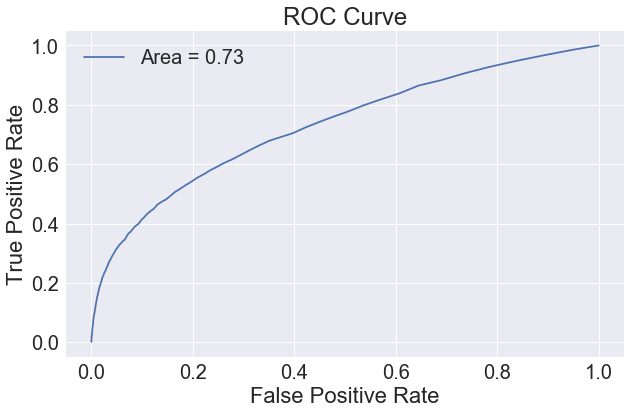

In [644]:
ax = plot_roc_curve(y_test, y_pred)

In [646]:
assert_is_instance(ax, mpl.axes.Axes, msg="Your function should return a matplotlib.axes.Axes object.")

assert_equal(len(ax.lines), 1)

assert_is_not(len(ax.title.get_text()), 0, msg="Your plot doesn't have a title.")
assert_is_not(ax.xaxis.get_label_text(), '', msg="Change the x-axis label to something more descriptive.")
assert_is_not(ax.yaxis.get_label_text(), '', msg="Change the y-axis label to something more descriptive.")
handles, labels = ax.get_legend_handles_labels()
assert_equal('area' in labels[0].lower() or 'auc' in labels[0].lower(), True)
assert_equal('{:0.2f}'.format(roc_auc_score(y_test, y_pred[:, 1])) in labels[0], True)

## Gradient Boosting Classifier

In [2]:
% matplotlib inline

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import ensemble
from sklearn.cross_validation import train_test_split
from sklearn.utils import check_random_state
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_absolute_error

from nose.tools import assert_equal, assert_is_instance, assert_is_not, assert_in
from numpy.testing import assert_array_equal, assert_array_almost_equal

import warnings
warnings.filterwarnings("ignore")

In [3]:
wines = pd.read_csv('wines.csv', 
                    names=['Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium',
                           'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
                           'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline'],
                    usecols=['Class', 'Alcohol', 'Ash', 'Alcalinity of ash', 'Total phenols'])

In [4]:
print(wines.head())

   Class  Alcohol   Ash  Alcalinity of ash  Total phenols
0      1    14.23  2.43               15.6           2.80
1      1    13.20  2.14               11.2           2.65
2      1    13.16  2.67               18.6           2.80
3      1    14.37  2.50               16.8           3.85
4      1    13.24  2.87               21.0           2.80


In [5]:
def split(df, test_column, test_size, random_state):
    '''
    Uses sklearn.train_test_split to split "df" into a testing set and a test set.
    The "test_columns" lists the column that we are trying to predict.
    All columns in "df" except "test_columns" will be used for training.
    The "test_size" should be between 0.0 and 1.0 and represents the proportion of the
    dataset to include in the test split.
    The "random_state" parameter is used in sklearn.train_test_split.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    test_columns: A list of strings
    test_size: A float
    random_state: A numpy.random.RandomState instance
    
    Returns
    -------
    A 4-tuple of pandas.DataFrames
    '''
    x=df.drop(test_column, axis=1)
    y=df[test_column]
    (X_train, X_test, y_train, y_test) = train_test_split(x, y, test_size=test_size,random_state=random_state)
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = split(
    df=wines,
    test_column=['Class'],
    test_size=0.2,
    random_state=check_random_state(0)
    )

In [16]:
def get_gbtc(n_estimators, random_state, max_depth=1):
    '''
    A gradient boosting classifier with two adjustable hyperparameters:
    "n_estimators" and (optional) "max_depth". 
    Don't forget to include "random_state".
    Uses the default sklearn values for the remaining parameters.
    
    Parameters
    ----------
    n_estimators: An int
    random_state: A numpy.random.RandomState instance
    max_depth: An int, optional
    
    Returns
    -------
    An sklearn.ensemble.GradientBoostingClassifier
    '''
    gbtc = GradientBoostingClassifier(n_estimators=n_estimators, random_state=random_state, max_depth=max_depth)
    return gbtc

In [19]:
t_gbtc = get_gbtc(200, check_random_state(2), max_depth=4)
assert_is_instance(t_gbtc, ensemble.GradientBoostingClassifier)
assert_equal(t_gbtc.n_estimators, 200)
assert_equal(t_gbtc.max_depth, 4)
assert_array_equal(t_gbtc.random_state.choice(100, 5), check_random_state(2).choice(100, 5))

In [21]:
def get_pred(gbtc, X_train, X_test, y_train):
    '''
    Fits the "gbtc" model on X_train and y_train.
    Makes predictions on X_test.
    
    Parameters
    ----------
    gbtc: A sklearn classifier instance.
    X_train: A pandas.DataFrame
    X_test: A pandas.DataFrame
    y_train: A pandas.DataFrame
    
    Returns
    -------
    A numpy array
    '''
    x_train=np.array(X_train)
    x_test=np.array(X_test)
    Y_train=np.array(y_train)
    gbtc.fit(x_train, Y_train)
    y_pred = gbtc.predict(x_test)
    return y_pred

In [22]:
t_gbtc = get_gbtc(200, check_random_state(1), max_depth=4)

t_X_train = pd.DataFrame({
    'X0': np.arange(100), 
    'X1': np.arange(-25, 75),
    })

t_y_train = pd.DataFrame({
    'y': list(np.arange(10))*10
    })

t_X_test = pd.DataFrame({
    'X0': np.arange(100),
    'X1': np.arange(100),
    })

test_pred = get_pred(t_gbtc, t_X_train, t_X_test, t_y_train)
assert_array_equal(test_pred, 
                   np.array([0, 1, 7, 3, 4, 0, 1, 2, 0, 4, 0, 1, 2, 3, 4, 0, 1, 2, 8, 4, 5, 1, 2,
                             8, 4, 5, 1, 7, 1, 4, 5, 1, 2, 3, 4, 5, 6, 7, 8, 2, 5, 6, 7, 3, 4, 5,
                             6, 7, 3, 4, 5, 6, 7, 3, 4, 5, 6, 7, 8, 9, 0, 6, 7, 3, 4, 0, 1, 7, 3,
                             4, 5, 1, 7, 8, 4, 5, 6, 7, 8, 9, 0, 1, 9, 3, 9, 5, 6, 7, 8, 9, 0, 1,
                             9, 9, 4, 5, 6, 7, 8, 9]))

y_pred = get_pred(t_gbtc, X_train, X_test, y_train)
assert_array_equal(y_pred, np.array([1, 3, 2, 1, 1, 2, 1, 2, 2, 2, 3, 3, 1, 2, 3, 2, 1, 1, 2, 1, 1, 1, 1,
                                     2, 2, 2, 2, 2, 2, 3, 1, 1, 2, 1, 1, 1]))

In [49]:
def get_best_param(X_train, y_train, n_estimators, random_state, max_depth_range):
    '''
    Implements a grid search on "max_depth" and returns the best "max_depth" value.
    
    Parameters
    ----------
    X_train: A pandas.DataFrame
    y_train: A pandas.DataFrame
    n_estimators: An int
    random_state: A numpy.random.RandomState instance
    max_depth_range: A numpy array of integers
    
    Returns
    -------
    An int
    '''
    gbtc=get_gbtc(n_estimators, random_state)
    param_grid = dict(max_depth=max_depth_range)
    grid= GridSearchCV(gbtc, param_grid)
    grid.fit(np.array(X_train), np.array(y_train).flatten())
    return grid.best_params_['max_depth']

In [50]:
t_best_max_depth = get_best_param(X_train, y_train, 500, check_random_state(0), np.arange(1, 7))
assert_equal(t_best_max_depth, 5)

In [71]:
def plot_mean_abs_error(X_train, X_test, y_train, y_test, n_estimators, random_state, best_max_depth):
    '''
    Using the best parameter we found, reconstructs a gradient boosting classifier.
    Fits the classifier and makes predictions.
    Gets mean absolute error for all individual estimators, and makes a plot
    of mean absolute value (on y-axis) vs. number of estimators (on x-axis)
    for both training data and testing data.
    Label your two curves as "Test" and "Train" (exact), respectively. 
    
    Paramters
    ---------
    X_train: A pandas.DataFrame
    X_test: A pandas.DataFrame
    y_train: A pandas.DataFrame
    y_test: A pandas.DataFrame
    n_estimators: An int
    random_state: A numpy.random.RandomState instance
    best_max_depth: An int
    
    Returns
    -------
    A matplotlib.Axes instance
    '''
    gbtc=get_gbtc(n_estimators=n_estimators, random_state=random_state, max_depth=best_max_depth)
    gbtc.fit(X_train, y_train)
    n_est = len(gbtc.estimators_)
    
    dev_test = np.zeros(n_est)
    dev_train = np.zeros(n_est)
    
    for idx, y_pred in enumerate(gbtc.staged_predict(X_test)):
        dev_test[idx] = mean_absolute_error(y_test, y_pred)
    
    for idx, y_pred in enumerate(gbtc.staged_predict(X_train)):
        dev_train[idx] = mean_absolute_error(y_train, y_pred)
        
    sns.set(style="white")
    sns.set(style="ticks", font_scale=2.0)
    fig, ax = plt.subplots(figsize=(10,6))
         
    ax.plot(np.arange(n_est) + 1, dev_test, color=sns.xkcd_rgb["denim blue"], label='Test', lw=3)
    ax.plot(np.arange(n_est) + 1, dev_train, color=sns.xkcd_rgb["pale red"], label='Train', lw=3)
    
    ax.set_title('Mean Absolute Error vs. # Estimators')
    ax.set_ylabel('Mean Absolute Error')
    ax.set_xlabel('# Estimators')
    ax.set_ylim((0.00, 0.14))
    ax.set_xlim((0, 160))
    
    sns.despine(offset=0, trim=True)
    sns.set(style="ticks", font_scale=2.0)
    ax.legend(loc=1)
    
    return ax

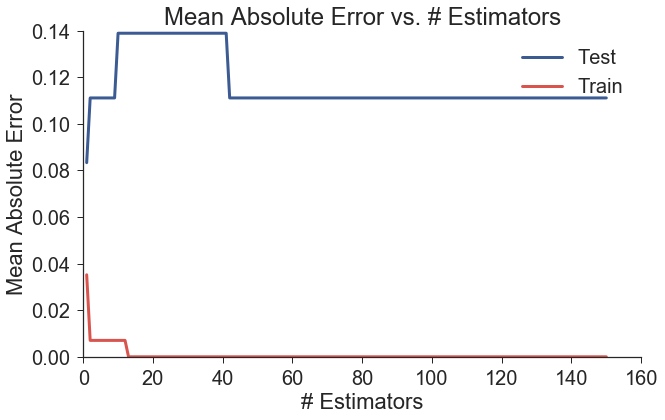

In [72]:
ax = plot_mean_abs_error(X_train, X_test, y_train, y_test, 150, check_random_state(0), t_best_max_depth)

In [73]:
assert_is_instance(ax, mpl.axes.Axes, msg="Your function should return a matplotlib.axes.Axes object.")

assert_equal(len(ax.lines), 2)

assert_is_not(len(ax.title.get_text()), 0, msg="Your plot doesn't have a title.")
assert_is_not(ax.xaxis.get_label_text(), '', msg="Change the x-axis label to something more descriptive.")
assert_is_not(ax.yaxis.get_label_text(), '', msg="Change the y-axis label to something more descriptive.")

handles, labels = ax.get_legend_handles_labels()
assert_equal(set(labels), set(['Train', 'Test']), msg="Make sure you have correct line labels.")

lines = ax.get_lines()
train = [l for l in lines if l.get_label()=='Train'][0]
test = [l for l in lines if l.get_label()=='Test'][0]

train_xdata = train.get_xdata()
train_ydata = train.get_ydata()

test_xdata = test.get_xdata()
test_ydata = test.get_ydata()

assert_array_almost_equal(train_xdata[:5], [1, 2, 3, 4, 5])
assert_array_almost_equal(train_ydata[:5], [0.03521127,  0.00704225,  0.00704225,  0.00704225,  0.00704225])

assert_array_almost_equal(test_xdata[:5], [1, 2, 3, 4, 5])
assert_array_almost_equal(test_ydata[:5], [0.08333333,  0.11111111,  0.11111111,  0.11111111,  0.11111111])